In [1]:
import os
import numpy as np
import ipynb
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from scipy.stats import levene, wilcoxon, ttest_rel
from cliffs_delta import cliffs_delta
from ipynb.fs.defs.functions_and_classes import Dataset, Datapoint
from ipynb.fs.defs.functions_and_classes import build_dict_from_vector_file, display_embedding_properties, load_dataset_from_csv

In [2]:
#model = 'word2vec'
model = 'glove'
dim = 50
language = 'he'
mode = 'mean'
ref = 'noun'

In [3]:
fname = f'{model}_{dim}_{language}_vectors_reduced.txt'
embedding = build_dict_from_vector_file('./models/reduced/', fname)
dataset = load_dataset_from_csv('./hebrew dataset/definitive_dataset.csv')
dataset.filter_against_embedding(embedding)

Processed 0 / 140 entries
Embedding entries: 140
Embedding dimension: 29
Number of datapoints before adjustment: 55
Number of datapoints after adjustment: 29


In [4]:
triplets = dataset.get_triplets()
print(triplets)

[['מחשב', 'למחשב', ['לחשב', 'להתחשב', 'לחשוב', 'להחשיב', 'להיחשב']], ['תחזוקה', 'לתחזק', ['לחזק', 'להתחזק', 'להחזיק']], ['תקשורת', 'לתקשר', ['לקשר', 'להתקשר', 'לקשור', 'להיקשר']], ['תפקידים', 'לתפקד', ['לפקד', 'להתפקד', 'לפקוד', 'להפקיד', 'להיפקד']], ['תרגילים', 'לתרגל', ['לרגל', 'להתרגל', 'להרגיל']], ['תזמורת', 'לתזמר', ['לזמר']], ['תזמון', 'לתזמן', ['לזמן', 'להזדמן', 'להזמין']], ['סקרנים', 'לסקרן', ['לסקר', 'לסקור', 'להיסקר']], ['סקרנים', 'להסתקרן', ['לסקר', 'לסקור', 'להיסקר']], ['מלכודת', 'למלכד', ['ללכד', 'להתלכד', 'ללכוד', 'להילכד']], ['אבטחה', 'לאבטח', ['לבטח', 'לבטוח', 'להבטיח']], ['מסגרת', 'למסגר', ['להסתגר', 'לסגור', 'להסגיר', 'להיסגר']], ['תעתיקים', 'לתעתק', ['להעתיק']], ['תמריצים', 'לתמרץ', ['להמריץ']], ['תצפית', 'לתצפת', ['לצפות']], ['אבחנות', 'לאבחן', ['לבחון', 'להבחין', 'להיבחן']], ['תחקיר', 'לתחקר', ['לחקור', 'להיחקר']], ['תקליטים', 'לתקלט', ['לקלוט', 'להקליט', 'להיקלט']], ['אזכרות', 'לאזכר', ['לזכור', 'להזכיר', 'להיזכר']], ['מספר', 'למספר', ['לספר', 'להסתפר', 'לספור', '

In [5]:
def compute_similarities(embedding, triplets, mode='mean', ref='noun'):
    """ If ref is 'noun', we collect noun/denominal and noun/other verb sims;
    if ref is 'denominal' we collect denominal/noun and denominal/other verb sims."""

    sims_n_dn = []
    sims_ref_ndn = []
    best_ndns = []
    for triplet in triplets:
        print(triplet)
        n = triplet[0]
        dn = triplet[1]
        ndns = triplet[2] #DO WE ALSO CONSIDER THE OTHER ROOT DERIVED ELEMENTS????
        
        sim_n_dn = 1 - cosine(embedding[n], embedding[dn])
        sims_n_dn.append(sim_n_dn)
        
        
        if ref =='noun':
            reference = n
        if ref == 'denominal':
            reference = dn
            
        if mode == 'best':
            index_best_ndn = np.argmax([1 - cosine(embedding[reference], embedding[ndn]) for ndn in ndns])
            best_ndn = ndns[index_best_ndn]
            best_ndn_vec = embedding[best_ndn]
            best_ndns.append(best_ndn)
            sim_ref_ndn = 1 - cosine(embedding[reference], best_ndn_vec)

        if mode == 'mean':
            #other_vec = np.mean([embedding[other_verb] for other_verb in other_verbs], axis=0)
            sim_ref_ndn = np.mean([1 - cosine(embedding[reference], embedding[ndn]) for ndn in ndns], axis=0)

        sims_ref_ndn.append(sim_ref_ndn)
        
    """for datapoint in dataset:
        noun = datapoint['noun']
        denominals = filter_empty_words(datapoint['denom'])
        non_denominals = filter_empty_words(datapoint['non_denom'])
        other_non_denominals = filter_empty_words(datapoint['others'])
        other_verbs = non_denominals+other_non_denominals

        for denominal in denominals:
            sim_n_dn = 1 - spatial.distance.cosine(embedding[noun], embedding[denominal])
            sims_n_dn.append(sim_n_dn)

            if ref =='noun':
                reference = noun
            if ref == 'denominal':
                reference = denominal

            if mode == 'best':
                index_best_ov = np.argmax([1 - spatial.distance.cosine(embedding[reference], embedding[other_verb]) for other_verb in other_verbs])
                best_ov = other_verbs[index_best_ov]
                other_vec = embedding[best_ov]
                triplets.append((noun, denominal, best_ov))
                sim_ref_other = 1 - spatial.distance.cosine(embedding[reference], other_vec)

            if mode == 'mean':
                #other_vec = np.mean([embedding[other_verb] for other_verb in other_verbs], axis=0)
                sim_ref_other = np.mean([1 - spatial.distance.cosine(embedding[reference], embedding[other_verb]) for other_verb in other_verbs], axis=0)

            sims_ref_ov.append(sim_ref_other)"""

    return (sims_n_dn, sims_ref_ndn, best_ndns)

In [6]:
sims_n_dn, sims_ref_ndn, best_ndns = compute_similarities(embedding, triplets, mode=mode, ref=ref)

['מחשב', 'למחשב', ['לחשב', 'להתחשב', 'לחשוב', 'להחשיב', 'להיחשב']]
['תחזוקה', 'לתחזק', ['לחזק', 'להתחזק', 'להחזיק']]
['תקשורת', 'לתקשר', ['לקשר', 'להתקשר', 'לקשור', 'להיקשר']]
['תפקידים', 'לתפקד', ['לפקד', 'להתפקד', 'לפקוד', 'להפקיד', 'להיפקד']]
['תרגילים', 'לתרגל', ['לרגל', 'להתרגל', 'להרגיל']]
['תזמורת', 'לתזמר', ['לזמר']]
['תזמון', 'לתזמן', ['לזמן', 'להזדמן', 'להזמין']]
['סקרנים', 'לסקרן', ['לסקר', 'לסקור', 'להיסקר']]
['סקרנים', 'להסתקרן', ['לסקר', 'לסקור', 'להיסקר']]
['מלכודת', 'למלכד', ['ללכד', 'להתלכד', 'ללכוד', 'להילכד']]
['אבטחה', 'לאבטח', ['לבטח', 'לבטוח', 'להבטיח']]
['מסגרת', 'למסגר', ['להסתגר', 'לסגור', 'להסגיר', 'להיסגר']]
['תעתיקים', 'לתעתק', ['להעתיק']]
['תמריצים', 'לתמרץ', ['להמריץ']]
['תצפית', 'לתצפת', ['לצפות']]
['אבחנות', 'לאבחן', ['לבחון', 'להבחין', 'להיבחן']]
['תחקיר', 'לתחקר', ['לחקור', 'להיחקר']]
['תקליטים', 'לתקלט', ['לקלוט', 'להקליט', 'להיקלט']]
['אזכרות', 'לאזכר', ['לזכור', 'להזכיר', 'להיזכר']]
['מספר', 'למספר', ['לספר', 'להסתפר', 'לספור', 'להיספר']]
['מרפק', '

In [7]:
def test_diff(sims_n_dn, sims_ref_ndn):
    diff_sims_dn_ndn = np.array(sims_n_dn) - np.array(sims_ref_ndn)
    print(f'Sample size: {len(diff_sims_dn_ndn)}')
    plt.hist(diff_sims_dn_ndn)
    plt.show()

    std = np.std(diff_sims_dn_ndn)
    mean = np.mean(diff_sims_dn_ndn)
    outp = [mean, std]
    print(f'Standard deviation: {std}')
    print(f'Mean: {mean}')

    _, p = levene(sims_n_dn, sims_ref_ndn)
    print(f'Levene p: {p}')

    if p > .05:
        print("F-test failed, performing Wilcoxon")
        outp.append('w')
        _, p = wilcoxon(sims_n_dn, sims_ref_ndn, zero_method='wilcox', correction=False, alternative='greater')
    else:
        print("F-test succeeded, performing t-test")
        outp.append('t')
        _, p = ttest_rel(sims_n_dn, sims_ref_ndn, alternative='greater')
        
    d, res = cliffs_delta(sims_n_dn, sims_ref_ndn)
    
    print(f'P-value: {p}')
    print(f'Effect size (Cliff\'s delta): {d} ({res})')
    outp.extend([p, d, res])

    return diff_sims_dn_ndn, outp


Sample size: 31


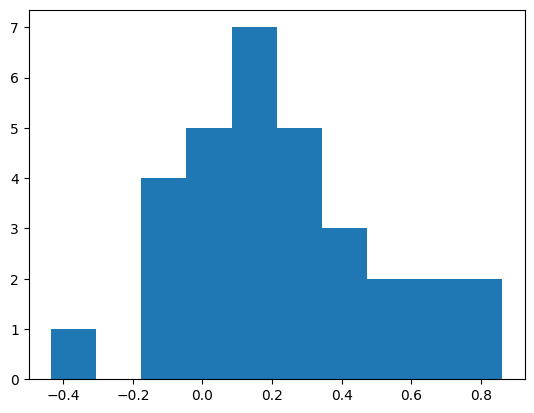

Standard deviation: 0.2846491308177501
Mean: 0.2262200995695593
Levene p: 0.8898723665387832
F-test failed, performing Wilcoxon
P-value: 5.338713526725769e-05
Effect size (Cliff's delta): 0.5442247658688866 (large)


In [8]:
diff_sims_dn_ndn, outp = test_diff(sims_n_dn, sims_ref_ndn)

In [9]:
outp

[0.2262200995695593,
 0.2846491308177501,
 'w',
 5.338713526725769e-05,
 0.5442247658688866,
 'large']

In [10]:
def save_report(model, dim, language, mode, ref, outp):
    mean, std, test, p, d, res = outp
    fname = f'{model}_{dim}_{language}_{mode}_{ref}_report.txt'
    with open(f'./reports/{fname}', 'w') as f:
        f.write(f'Mean: {mean}\n')
        f.write(f'Std: {std}\n')
        f.write(f'Test: {test}\n')
        f.write(f'P-value: {p}\n')
        f.write(f"Cliff' s delta': {d}\n")
        f.write(f'Effect: {res}\n')


In [11]:
save_report(model, dim, language, mode, ref, outp)